In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
!pip install gensim

In [3]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 28.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 

In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred

In [5]:
print(pd.__version__)

2.1.1


In [6]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [8]:
from google.colab import files
uploaded= files.upload()

Saving Split_data_final.xlsx to Split_data_final.xlsx


In [9]:
import io
#data=pd.read_excel(uploaded['Split_data_final.xlsx'])
data=pd.read_excel("/content/Split_data_final.xlsx")

In [10]:
data_L=pd.DataFrame()
data=data.dropna(subset=["Threat"])
data_L=data.loc[data["AV"]=="L"]
data_L["Threat"].nunique()
data_L = data_L.drop_duplicates(subset=['Threat'])

In [11]:
data_L["Threat"].nunique()

224

In [12]:
# Convert to list
data = data_L.Threat.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['The GRUB2 boot loader is vulnerable to buffer overflow, which results in '
 'arbitrary code execution during the boot process, even when Secure Boot is '
 'enabled. Note: The fix provided by the vendor for this advisory has known '
 'issues. BootHole fixes may prevent some users from booting their systems. '
 'Please refer to this link '
 '(https://bugs.launchpad.net/ubuntu/+source/grub2/+bug/1889556) for more '
 'details. This QID detection would be updated as deemed necessary once the '
 'vendor releases updated packages.']


In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'grub', 'boot', 'loader', 'is', 'vulnerable', 'to', 'buffer', 'overflow', 'which', 'results', 'in', 'arbitrary', 'code', 'execution', 'during', 'the', 'boot', 'process', 'even', 'when', 'secure', 'boot', 'is', 'enabled', 'note', 'the', 'fix', 'provided', 'by', 'the', 'vendor', 'for', 'this', 'advisory', 'has', 'known', 'issues', 'boothole', 'fixes', 'may', 'prevent', 'some', 'users', 'from', 'booting', 'their', 'systems', 'please', 'refer', 'to', 'this', 'link', 'https', 'bugs', 'launchpad', 'net', 'ubuntu', 'source', 'grub', 'bug', 'for', 'more', 'details', 'this', 'qid', 'detection', 'would', 'be', 'updated', 'as', 'deemed', 'necessary', 'once', 'the', 'vendor', 'releases', 'updated', 'packages']]


In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'grub', 'boot_loader', 'is', 'vulnerable', 'to', 'buffer', 'overflow', 'which', 'results', 'in', 'arbitrary', 'code', 'execution', 'during', 'the', 'boot', 'process', 'even', 'when', 'secure', 'boot', 'is', 'enabled', 'note', 'the', 'fix', 'provided', 'by', 'the', 'vendor', 'for', 'this', 'advisory', 'has', 'known', 'issues', 'boothole', 'fixes', 'may', 'prevent', 'some', 'users', 'from', 'booting', 'their', 'systems', 'please', 'refer', 'to', 'this', 'link', 'https', 'bugs', 'launchpad', 'net', 'ubuntu', 'source', 'grub', 'bug', 'for', 'more', 'details', 'this', 'qid', 'detection', 'would', 'be', 'updated', 'as', 'deemed', 'necessary', 'once', 'the', 'vendor', 'releases', 'updated', 'packages']


In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
!python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

2023-09-25 18:01:20.123213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
[['grub', 'vulnerable', 'buffer', 'overflow', 'result', 'arbitrary', 'code', 'execution', 'boot', 'process', 'even', 'secure', 'boot', 'enable', 'note', 'fix', 'provide', 'vendor', 'advisory', 'know', 'issue', 'boothole', 'fix', 'prevent', 'user', 'boot', 'system', 'refer', 'link', 'bug', 'source', 'grub', 'bug', 'detail', 'detection', 'update', 'deem', 'necessary', 'vendor', 'release', 'update', 'package']]


In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 2), (34, 1)]]


In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advisory', 1),
  ('arbitrary', 1),
  ('boot', 3),
  ('boothole', 1),
  ('buffer', 1),
  ('bug', 2),
  ('code', 1),
  ('deem', 1),
  ('detail', 1),
  ('detection', 1),
  ('enable', 1),
  ('even', 1),
  ('execution', 1),
  ('fix', 2),
  ('grub', 2),
  ('issue', 1),
  ('know', 1),
  ('link', 1),
  ('necessary', 1),
  ('note', 1),
  ('overflow', 1),
  ('package', 1),
  ('prevent', 1),
  ('process', 1),
  ('provide', 1),
  ('refer', 1),
  ('release', 1),
  ('result', 1),
  ('secure', 1),
  ('source', 1),
  ('system', 1),
  ('update', 2),
  ('user', 1),
  ('vendor', 2),
  ('vulnerable', 1)]]

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.083*"guest" + 0.058*"system" + 0.030*"hypervisor" + 0.028*"core" + '
  '0.028*"privileged" + 0.026*"trigger" + 0.024*"run" + 0.023*"user" + '
  '0.023*"error" + 0.023*"svga"'),
 (1,
  '0.138*"esx" + 0.051*"vulnerability" + 0.049*"affect" + 0.046*"service" + '
  '0.036*"update" + 0.032*"console" + 0.030*"release" + 0.024*"product" + '
  '0.023*"security" + 0.022*"fix"'),
 (2,
  '0.096*"enterprise" + 0.075*"red" + 0.059*"update" + 0.049*"hat" + '
  '0.044*"support" + 0.041*"server" + 0.032*"extend" + 0.030*"service" + '
  '0.025*"endian" + 0.024*"ppc"'),
 (3,
  '0.066*"version" + 0.028*"use" + 0.026*"command" + 0.026*"user" + '
  '0.023*"appliance" + 0.022*"root" + 0.021*"check" + 0.020*"provide" + '
  '0.019*"unauthenticated" + 0.016*"remote"'),
 (4,
  '0.037*"check" + 0.035*"information" + 0.034*"memory" + '
  '0.032*"detection_logic" + 0.027*"speculative_execution" + 0.027*"local" + '
  '0.026*"allow" + 0.024*"cpu" + 0.023*"read" + 0.023*"cve"'),
 (5,
  '0.125*"vmware" + 0.0

In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.401598835137957

Coherence Score:  0.48719016271065435


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.267317 -0.066230       1        1  26.861611
6     -0.155727 -0.201974       2        1  20.774110
7      0.290630 -0.036483       3        1  19.640693
5     -0.030166  0.332759       4        1  12.890761
4     -0.158037 -0.020045       5        1  11.182028
3     -0.150345  0.075136       6        1   3.271024
1      0.029077  0.059987       7        1   2.796337
0     -0.092749 -0.143150       8        1   2.583437, topic_info=           Term        Freq       Total Category  logprob  loglift
467         hat  419.000000  419.000000  Default  30.0000  30.0000
464  enterprise  591.000000  591.000000  Default  29.0000  29.0000
956      vmware  178.000000  178.000000  Default  28.0000  28.0000
480         red  439.000000  439.000000  Default  27.0000  27.0000
37     discover  195.000000  195.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
125      device    5.553960   57.003578   Topic8  -3.9337   1.3274
330         cve    5.958593  138.083251   Topic8  -3.8634   0.5130
158     virtual    2.815647   39.052617   Topic8  -4.6130   1.0263
87    condition    2.237448   22.644770   Topic8  -4.8429   1.3415
159       allow    2.287428   44.640659   Topic8  -4.8208   0.6848

[411 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
454       1  0.943417        aarch
1057      7  0.892696     abstract
269       1  0.150397       access
269       2  0.210556       access
269       5  0.631669       access
...     ...       ...          ...
754       4  0.125268  workstation
45        1  0.124705        write
45        3  0.124705        write
45        5  0.748229        write
825       3  0.896555          zip

[488 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 8, 6, 5, 4, 2, 1])

In [23]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.20.1" 2023-08-24
OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)


In [24]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2023-09-25 18:01:59--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2023-09-25 18:01:59--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  17.1MB/s    in 0.9s    

2023-09-25 18:02:00 (17.1 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [25]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this

In [26]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# Copyright (C) 2014 Radim Rehurek <radimrehurek@seznam.cz>
# Licensed under the GNU LGPL v2.1 - http://www.gnu.org/licenses/lgpl.html


r"""Python wrapper for `Latent Dirichlet Allocation (LDA) <https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation>`_
from `MALLET, the Java topic modelling toolkit <http://mallet.cs.umass.edu/>`_

This module allows both LDA model estimation from a training corpus and inference of topic distribution on new,
unseen documents, using an (optimized version of) collapsed gibbs sampling from MALLET.

Notes
-----
MALLET's LDA training requires :math:`O(corpus\_words)` of memory, keeping the entire corpus in RAM.
If you find yourself running out of memory, either decrease the `workers` constructor parameter,
or use :class:`gensim.models.ldamodel.LdaModel` or :class:`gensim.models.ldamulticore.LdaMulticore`
which needs only :math:`O(1)` memory.
The wrapped model can NOT be updated with new documents for online training -- use
:class:`~gensim.models.ldamodel.LdaModel` or :class:`~gensim.models.ldamulticore.LdaMulticore` for that.

Installation
------------
Use `official guide <http://mallet.cs.umass.edu/download.php>`_ or this one ::

    sudo apt-get install default-jdk
    sudo apt-get install ant
    git clone git@github.com:mimno/Mallet.git
    cd Mallet/
    ant

Examples
--------
.. sourcecode:: pycon

    >>> from gensim.test.utils import common_corpus, common_dictionary
    >>> from gensim.models.wrappers import LdaMallet
    >>>
    >>> path_to_mallet_binary = "/path/to/mallet/binary"
    >>> model = LdaMallet(path_to_mallet_binary, corpus=common_corpus, num_topics=20, id2word=common_dictionary)
    >>> vector = model[common_corpus[0]]  # LDA topics of a documents

"""


import logging
import os
import random
import warnings
import tempfile
import xml.etree.ElementTree as et
import zipfile
from itertools import chain

import numpy

from gensim import utils, matutils
from gensim.models import basemodel
from gensim.models.ldamodel import LdaModel
from gensim.utils import check_output, revdict

logger = logging.getLogger(__name__)


class LdaMallet(utils.SaveLoad, basemodel.BaseTopicModel):
    """Python wrapper for LDA using `MALLET <http://mallet.cs.umass.edu/>`_.

    Communication between MALLET and Python takes place by passing around data files on disk
    and calling Java with subprocess.call().

    Warnings
    --------
    This is **only** python wrapper for `MALLET LDA <http://mallet.cs.umass.edu/>`_,
    you need to install original implementation first and pass the path to binary to ``mallet_path``.

    """
    def __init__(self, mallet_path, corpus=None, num_topics=100, alpha=50, id2word=None, workers=4, prefix=None,
                 optimize_interval=0, iterations=1000, topic_threshold=0.0, random_seed=0):
        """

        Parameters
        ----------
        mallet_path : str
            Path to the mallet binary, e.g. `/home/username/mallet-2.0.7/bin/mallet`.
        corpus : iterable of iterable of (int, int), optional
            Collection of texts in BoW format.
        num_topics : int, optional
            Number of topics.
        alpha : int, optional
            Alpha parameter of LDA.
        id2word : :class:`~gensim.corpora.dictionary.Dictionary`, optional
            Mapping between tokens ids and words from corpus, if not specified - will be inferred from `corpus`.
        workers : int, optional
            Number of threads that will be used for training.
        prefix : str, optional
            Prefix for produced temporary files.
        optimize_interval : int, optional
            Optimize hyperparameters every `optimize_interval` iterations
            (sometimes leads to Java exception 0 to switch off hyperparameter optimization).
        iterations : int, optional
            Number of training iterations.
        topic_threshold : float, optional
            Threshold of the probability above which we consider a topic.
        random_seed: int, optional
            Random seed to ensure consistent results, if 0 - use system clock.

        """
        self.mallet_path = mallet_path
        self.id2word = id2word
        if self.id2word is None:
            logger.warning("no word id mapping provided; initializing from corpus, assuming identity")
            self.id2word = utils.dict_from_corpus(corpus)
            self.num_terms = len(self.id2word)
        else:
            self.num_terms = 0 if not self.id2word else 1 + max(self.id2word.keys())
        if self.num_terms == 0:
            raise ValueError("cannot compute LDA over an empty collection (no terms)")
        self.num_topics = num_topics
        self.topic_threshold = topic_threshold
        self.alpha = alpha
        if prefix is None:
            rand_prefix = hex(random.randint(0, 0xffffff))[2:] + '_'
            prefix = os.path.join(tempfile.gettempdir(), rand_prefix)
        self.prefix = prefix
        self.workers = workers
        self.optimize_interval = optimize_interval
        self.iterations = iterations
        self.random_seed = random_seed
        if corpus is not None:
            self.train(corpus)

    def finferencer(self):
        """Get path to inferencer.mallet file.

        Returns
        -------
        str
            Path to inferencer.mallet file.

        """
        return self.prefix + 'inferencer.mallet'

    def ftopickeys(self):
        """Get path to topic keys text file.

        Returns
        -------
        str
            Path to topic keys text file.

        """
        return self.prefix + 'topickeys.txt'

    def fstate(self):
        """Get path to temporary file.

        Returns
        -------
        str
            Path to file.

        """
        return self.prefix + 'state.mallet.gz'

    def fdoctopics(self):
        """Get path to document topic text file.

        Returns
        -------
        str
            Path to document topic text file.

        """
        return self.prefix + 'doctopics.txt'

    def fcorpustxt(self):
        """Get path to corpus text file.

        Returns
        -------
        str
            Path to corpus text file.

        """
        return self.prefix + 'corpus.txt'

    def fcorpusmallet(self):
        """Get path to corpus.mallet file.

        Returns
        -------
        str
            Path to corpus.mallet file.

        """
        return self.prefix + 'corpus.mallet'

    def fwordweights(self):
        """Get path to word weight file.

        Returns
        -------
        str
            Path to word weight file.

        """
        return self.prefix + 'wordweights.txt'

    def corpus2mallet(self, corpus, file_like):
        """Convert `corpus` to Mallet format and write it to `file_like` descriptor.

        Format ::

            document id[SPACE]label (not used)[SPACE]whitespace delimited utf8-encoded tokens[NEWLINE]

        Parameters
        ----------
        corpus : iterable of iterable of (int, int)
            Collection of texts in BoW format.
        file_like : file-like object
            Opened file.

        """
        for docno, doc in enumerate(corpus):
            if self.id2word:
                tokens = chain.from_iterable([self.id2word[tokenid]] * int(cnt) for tokenid, cnt in doc)
            else:
                tokens = chain.from_iterable([str(tokenid)] * int(cnt) for tokenid, cnt in doc)
            file_like.write(utils.to_utf8("%s 0 %s\n" % (docno, ' '.join(tokens))))

    def convert_input(self, corpus, infer=False, serialize_corpus=True):
        """Convert corpus to Mallet format and save it to a temporary text file.

        Parameters
        ----------
        corpus : iterable of iterable of (int, int)
            Collection of texts in BoW format.
        infer : bool, optional
            ...
        serialize_corpus : bool, optional
            ...

        """
        if serialize_corpus:
            logger.info("serializing temporary corpus to %s", self.fcorpustxt())
            with utils.open(self.fcorpustxt(), 'wb') as fout:
                self.corpus2mallet(corpus, fout)

        # convert the text file above into MALLET's internal format
        cmd = \
            self.mallet_path + \
            " import-file --preserve-case --keep-sequence " \
            "--remove-stopwords --token-regex \"\\S+\" --input %s --output %s"
        if infer:
            cmd += ' --use-pipe-from ' + self.fcorpusmallet()
            cmd = cmd % (self.fcorpustxt(), self.fcorpusmallet() + '.infer')
        else:
            cmd = cmd % (self.fcorpustxt(), self.fcorpusmallet())
        logger.info("converting temporary corpus to MALLET format with %s", cmd)
        check_output(args=cmd, shell=True)

    def train(self, corpus):
        """Train Mallet LDA.

        Parameters
        ----------
        corpus : iterable of iterable of (int, int)
            Corpus in BoW format

        """
        self.convert_input(corpus, infer=False)
        cmd = self.mallet_path + ' train-topics --input %s --num-topics %s  --alpha %s --optimize-interval %s '\
            '--num-threads %s --output-state %s --output-doc-topics %s --output-topic-keys %s '\
            '--num-iterations %s --inferencer-filename %s --doc-topics-threshold %s  --random-seed %s'

        cmd = cmd % (
            self.fcorpusmallet(), self.num_topics, self.alpha, self.optimize_interval,
            self.workers, self.fstate(), self.fdoctopics(), self.ftopickeys(), self.iterations,
            self.finferencer(), self.topic_threshold, str(self.random_seed)
        )
        # NOTE "--keep-sequence-bigrams" / "--use-ngrams true" poorer results + runs out of memory
        logger.info("training MALLET LDA with %s", cmd)
        check_output(args=cmd, shell=True)
        self.word_topics = self.load_word_topics()
        # NOTE - we are still keeping the wordtopics variable to not break backward compatibility.
        # word_topics has replaced wordtopics throughout the code;
        # wordtopics just stores the values of word_topics when train is called.
        self.wordtopics = self.word_topics

    def __getitem__(self, bow, iterations=100):
        """Get vector for document(s).

        Parameters
        ----------
        bow : {list of (int, int), iterable of list of (int, int)}
            Document (or corpus) in BoW format.
        iterations : int, optional
            Number of iterations that will be used for inferring.

        Returns
        -------
        list of (int, float)
            LDA vector for document as sequence of (topic_id, topic_probability) **OR**
        list of list of (int, float)
            LDA vectors for corpus in same format.

        """
        is_corpus, corpus = utils.is_corpus(bow)
        if not is_corpus:
            # query is a single document => make a corpus out of it
            bow = [bow]

        self.convert_input(bow, infer=True)
        cmd = \
            self.mallet_path + ' infer-topics --input %s --inferencer %s ' \
                               '--output-doc-topics %s --num-iterations %s --doc-topics-threshold %s --random-seed %s'
        cmd = cmd % (
            self.fcorpusmallet() + '.infer', self.finferencer(),
            self.fdoctopics() + '.infer', iterations, self.topic_threshold, str(self.random_seed)
        )
        logger.info("inferring topics with MALLET LDA '%s'", cmd)
        check_output(args=cmd, shell=True)
        result = list(self.read_doctopics(self.fdoctopics() + '.infer'))
        return result if is_corpus else result[0]

    def load_word_topics(self):
        """Load words X topics matrix from :meth:`gensim.models.wrappers.ldamallet.LdaMallet.fstate` file.

        Returns
        -------
        numpy.ndarray
            Matrix words X topics.

        """
        logger.info("loading assigned topics from %s", self.fstate())
        word_topics = numpy.zeros((self.num_topics, self.num_terms), dtype=numpy.float64)
        if hasattr(self.id2word, 'token2id'):
            word2id = self.id2word.token2id
        else:
            word2id = revdict(self.id2word)

        with utils.open(self.fstate(), 'rb') as fin:
            _ = next(fin)  # header
            self.alpha = numpy.fromiter(next(fin).split()[2:], dtype=float)
            assert len(self.alpha) == self.num_topics, "mismatch between MALLET vs. requested topics"
            _ = next(fin)  # noqa:F841 beta
            for lineno, line in enumerate(fin):
                line = utils.to_unicode(line)
                doc, source, pos, typeindex, token, topic = line.split(" ")
                if token not in word2id:
                    continue
                tokenid = word2id[token]
                word_topics[int(topic), tokenid] += 1.0
        return word_topics

    def load_document_topics(self):
        """Load document topics from :meth:`gensim.models.wrappers.ldamallet.LdaMallet.fdoctopics` file.
        Shortcut for :meth:`gensim.models.wrappers.ldamallet.LdaMallet.read_doctopics`.

        Returns
        -------
        iterator of list of (int, float)
            Sequence of LDA vectors for documents.

        """
        return self.read_doctopics(self.fdoctopics())

    def get_topics(self):
        """Get topics X words matrix.

        Returns
        -------
        numpy.ndarray
            Topics X words matrix, shape `num_topics` x `vocabulary_size`.

        """
        topics = self.word_topics
        return topics / topics.sum(axis=1)[:, None]

    def show_topics(self, num_topics=10, num_words=10, log=False, formatted=True):
        """Get the `num_words` most probable words for `num_topics` number of topics.

        Parameters
        ----------
        num_topics : int, optional
            Number of topics to return, set `-1` to get all topics.
        num_words : int, optional
            Number of words.
        log : bool, optional
            If True - write topic with logging too, used for debug proposes.
        formatted : bool, optional
            If `True` - return the topics as a list of strings, otherwise as lists of (weight, word) pairs.

        Returns
        -------
        list of str
            Topics as a list of strings (if formatted=True) **OR**
        list of (float, str)
            Topics as list of (weight, word) pairs (if formatted=False)

        """
        if num_topics < 0 or num_topics >= self.num_topics:
            num_topics = self.num_topics
            chosen_topics = range(num_topics)
        else:
            num_topics = min(num_topics, self.num_topics)
            # add a little random jitter, to randomize results around the same alpha
            sort_alpha = self.alpha + 0.0001 * numpy.random.rand(len(self.alpha))
            sorted_topics = list(matutils.argsort(sort_alpha))
            chosen_topics = sorted_topics[: num_topics // 2] + sorted_topics[-num_topics // 2:]
        shown = []
        for i in chosen_topics:
            if formatted:
                topic = self.print_topic(i, topn=num_words)
            else:
                topic = self.show_topic(i, topn=num_words)
            shown.append((i, topic))
            if log:
                logger.info("topic #%i (%.3f): %s", i, self.alpha[i], topic)
        return shown

    def show_topic(self, topicid, topn=10, num_words=None):
        """Get `num_words` most probable words for the given `topicid`.

        Parameters
        ----------
        topicid : int
            Id of topic.
        topn : int, optional
            Top number of topics that you'll receive.
        num_words : int, optional
            DEPRECATED PARAMETER, use `topn` instead.

        Returns
        -------
        list of (str, float)
            Sequence of probable words, as a list of `(word, word_probability)` for `topicid` topic.

        """
        if num_words is not None:  # deprecated num_words is used
            warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
            topn = num_words

        if self.word_topics is None:
            logger.warning("Run train or load_word_topics before showing topics.")
        topic = self.word_topics[topicid]
        topic = topic / topic.sum()  # normalize to probability dist
        bestn = matutils.argsort(topic, topn, reverse=True)
        beststr = [(self.id2word[idx], topic[idx]) for idx in bestn]
        return beststr

    def get_version(self, direc_path):
        """"Get the version of Mallet.

        Parameters
        ----------
        direc_path : str
            Path to mallet archive.

        Returns
        -------
        str
            Version of mallet.

        """
        try:
            archive = zipfile.ZipFile(direc_path, 'r')
            if u'cc/mallet/regression/' not in archive.namelist():
                return '2.0.7'
            else:
                return '2.0.8RC3'
        except Exception:

            xml_path = direc_path.split("bin")[0]
            try:
                doc = et.parse(xml_path + "pom.xml").getroot()
                namespace = doc.tag[:doc.tag.index('}') + 1]
                return doc.find(namespace + 'version').text.split("-")[0]
            except Exception:
                return "Can't parse pom.xml version file"

    def read_doctopics(self, fname, eps=1e-6, renorm=True):
        """Get document topic vectors from MALLET's "doc-topics" format, as sparse gensim vectors.

        Parameters
        ----------
        fname : str
            Path to input file with document topics.
        eps : float, optional
            Threshold for probabilities.
        renorm : bool, optional
            If True - explicitly re-normalize distribution.

        Raises
        ------
        RuntimeError
            If any line in invalid format.

        Yields
        ------
        list of (int, float)
            LDA vectors for document.

        """
        mallet_version = self.get_version(self.mallet_path)
        with utils.open(fname, 'rb') as fin:
            for lineno, line in enumerate(fin):
                if lineno == 0 and line.startswith(b"#doc "):
                    continue  # skip the header line if it exists

                parts = line.split()[2:]  # skip "doc" and "source" columns

                # the MALLET doctopic format changed in 2.0.8 to exclude the id,
                # this handles the file differently dependent on the pattern
                if len(parts) == 2 * self.num_topics:
                    doc = [
                        (int(id_), float(weight)) for id_, weight in zip(*[iter(parts)] * 2)
                        if abs(float(weight)) > eps
                    ]
                elif len(parts) == self.num_topics and mallet_version != '2.0.7':
                    doc = [(id_, float(weight)) for id_, weight in enumerate(parts) if abs(float(weight)) > eps]
                else:
                    if mallet_version == "2.0.7":
                        """

                            1   1   0   1.0780612802674239  30.005575655428533364   2   0.005575655428533364
                            2   2   0   0.9184413079632608  40.009062076892971008   3   0.009062076892971008
                            In the above example there is a mix of the above if and elif statement.
                            There are neither `2*num_topics` nor `num_topics` elements.
                            It has 2 formats 40.009062076892971008 and 0   1.0780612802674239
                            which cannot be handled by above if elif.
                            Also, there are some topics are missing(meaning that the topic is not there)
                            which is another reason why the above if elif fails even when the `mallet`
                            produces the right results

                        """
                        count = 0
                        doc = []
                        if len(parts) > 0:
                            while count < len(parts):
                                """
                                if section is to deal with formats of type 2 0.034
                                so if count reaches index of 2 and since int(2) == float(2) so if block is executed
                                now  there is one extra element afer 2, so count + 1 access should not give an error

                                else section handles  formats of type 20.034
                                now count is there on index of 20.034 since float(20.034) != int(20.034) so else block
                                is executed

                                """
                                if float(parts[count]) == int(parts[count]):
                                    if float(parts[count + 1]) > eps:
                                        doc.append((int(parts[count]), float(parts[count + 1])))
                                    count += 2
                                else:
                                    if float(parts[count]) - int(parts[count]) > eps:
                                        doc.append((int(parts[count]) % 10, float(parts[count]) - int(parts[count])))
                                    count += 1
                    else:
                        raise RuntimeError("invalid doc topics format at line %i in %s" % (lineno + 1, fname))

                if renorm:
                    # explicitly normalize weights to sum up to 1.0, just to be sure...
                    total_weight = float(sum(weight for _, weight in doc))
                    if total_weight:
                        doc = [(id_, float(weight) / total_weight) for id_, weight in doc]
                yield doc

    @classmethod
    def load(cls, *args, **kwargs):
        """Load a previously saved LdaMallet class. Handles backwards compatibility from
        older LdaMallet versions which did not use random_seed parameter.
        """
        model = super(LdaMallet, cls).load(*args, **kwargs)
        if not hasattr(model, 'random_seed'):
            model.random_seed = 0

        return model


def malletmodel2ldamodel(mallet_model, gamma_threshold=0.001, iterations=50):
    """Convert :class:`~gensim.models.wrappers.ldamallet.LdaMallet` to :class:`~gensim.models.ldamodel.LdaModel`.

    This works by copying the training model weights (alpha, beta...) from a trained mallet model into the gensim model.

    Parameters
    ----------
    mallet_model : :class:`~gensim.models.wrappers.ldamallet.LdaMallet`
        Trained Mallet model
    gamma_threshold : float, optional
        To be used for inference in the new LdaModel.
    iterations : int, optional
        Number of iterations to be used for inference in the new LdaModel.

    Returns
    -------
    :class:`~gensim.models.ldamodel.LdaModel`
        Gensim native LDA.

    """
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
        iterations=iterations,
        gamma_threshold=gamma_threshold,
        dtype=numpy.float64  # don't loose precision when converting from MALLET
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [27]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#mallet_path = 'path/to/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [28]:
#!pip install --upgrade gensim==3.8

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

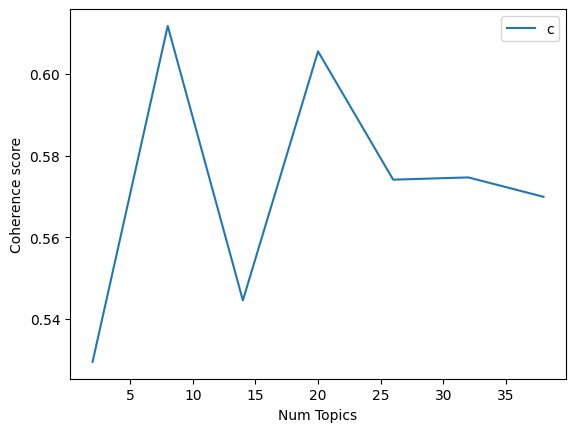

In [31]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5295
Num Topics = 8  has Coherence Value of 0.6118
Num Topics = 14  has Coherence Value of 0.5445
Num Topics = 20  has Coherence Value of 0.6056
Num Topics = 26  has Coherence Value of 0.5741
Num Topics = 32  has Coherence Value of 0.5747
Num Topics = 38  has Coherence Value of 0.5699


In [33]:
print(pd.__version__)

2.1.1


In [34]:
#!pip install pandas==1.5.3

In [35]:
print(pd.__version__)

2.1.1
